In [1]:
import pandas as pd
df = pd.read_csv("IMDB Dataset.csv")

In [2]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.shape

(50000, 2)

[]

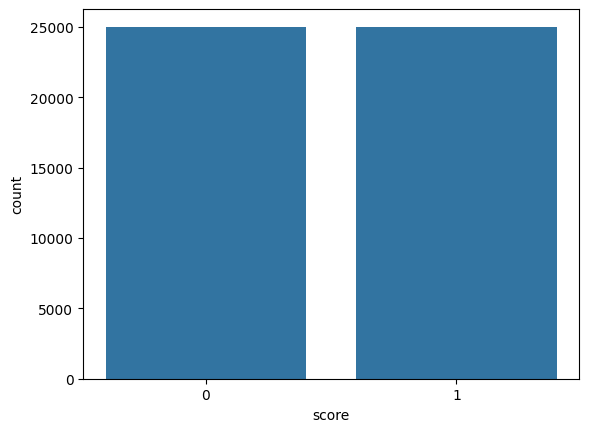

In [4]:
df['score'] = df['sentiment'].apply(lambda x: 1 if x=='positive' else 0)
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='score',data = df)
plt.plot()

In [5]:
df.isnull().sum()

review       0
sentiment    0
score        0
dtype: int64

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to C:\Users\Swapna
[nltk_data]     Kundu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Swapna
[nltk_data]     Kundu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Swapna
[nltk_data]     Kundu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
import re
import string
from torch.nn.utils.rnn import pad_sequence
def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'<.*?>', '', text)  # remove HTML tags
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra whitespace
    return text
def preprocess_text(text):
    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)

    filtered =[ words for words in tokens if words not in stop_words and words not in punctuation]

    return filtered


In [8]:
texts = df['review'].astype(str).tolist()

In [9]:
cleaned_text =[clean_text(text) for text in texts]

In [10]:
filtered_texts =[preprocess_text(text) for text in cleaned_text]

In [11]:
vocab ={"<PAD>" : 0, "<UNK>":1}
for sentence in filtered_texts:
  for item in sentence:
      if item not in vocab:
         vocab[item] = len(vocab)

In [12]:
encoded = []
for sentence in filtered_texts:
    ids = [vocab.get(word, vocab["<UNK>"]) for word in sentence]
    encoded.append(torch.tensor(ids))


In [13]:
label = df['score'].tolist()

In [14]:
len_list=[]

for i in range(df.shape[0]):
  len_list.append(len(encoded[i]))

print(max(len_list))

1420


(0.0, 1500.0)

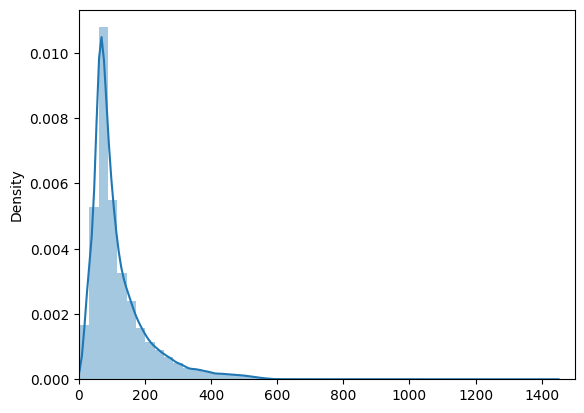

In [21]:
sns.distplot(len_list)
plt.xlim([0,1500])

In [22]:
max_len = 512
encoded = [seq[:max_len] for seq in encoded]
padded = pad_sequence(encoded, batch_first=True, padding_value=vocab["<PAD>"])
print(padded)

tensor([[    2,     3,     4,  ...,     0,     0,     0],
        [  144,   145,   146,  ...,     0,     0,     0],
        [  214,   144,   215,  ...,     0,     0,     0],
        ...,
        [12020, 17618, 73855,  ...,     0,     0,     0],
        [  689,   303, 10783,  ...,     0,     0,     0],
        [    2,  9214,   675,  ...,     0,     0,     0]])


In [23]:
X = padded
y = label

In [24]:
from sklearn.model_selection import train_test_split
X_train,X_temp,y_train,y_temp = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

In [25]:
X_val,X_test,y_val,y_test = train_test_split(X_temp,y_temp,test_size=0.5,random_state=42,stratify=y_temp)

In [26]:
X_train_tensor = torch.tensor(X_train,dtype = torch.long)
y_train_tensor = torch.tensor(y_train,dtype = torch.long)
X_val_tensor = torch.tensor(X_val,dtype = torch.long)
y_val_tensor = torch.tensor(y_val,dtype = torch.long)
X_test_tensor = torch.tensor(X_test,dtype = torch.long)
y_test_tensor = torch.tensor(y_test,dtype = torch.long)

In [27]:
class customset(Dataset):
    def __init__(self,X,y):
        super().__init__()
        self.X = X
        self.y = y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, index):
        return self.X[index],self.y[index]

In [28]:
train_dataset = customset(X_train_tensor,y_train_tensor)
val_dataset = customset(X_val_tensor,y_val_tensor)
test_dataset = customset(X_test_tensor,y_test_tensor)

In [29]:
train_loader = DataLoader(train_dataset,batch_size=16,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=16)
test_loader = DataLoader(test_dataset,batch_size=16)

In [30]:
import math

class PositionalEncoding(nn.Module):
  def __init__(self, d_model, seq_len , dropout):
    super().__init__()
    self.d_model = d_model
    self.seq_len = seq_len
    self.dropout = nn.Dropout(dropout)

    pe = torch.zeros(seq_len, d_model)
    pos = torch.arange(0,seq_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0,d_model,2).float() * (-math.log(10000.0)/d_model))

    pe[:,0::2] = torch.sin(pos * div_term)
    pe[:,1::2] = torch.cos(pos * div_term)

    pe = pe.unsqueeze(0)

    self.register_buffer('pe',pe)
  def forward(self,x):
    x = x + (self.pe[:,:x.shape[1],:]).to(x.device)
    return self.dropout(x)

class FeedForward(nn.Module):
  def __init__(self, d_model, dim_ff, dropout=0.1):
    super().__init__()
    self.network = nn.Sequential(
        nn.Linear(d_model, dim_ff),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(dim_ff,d_model)
    )
  def forward(self,x):
    return self.network(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, h: int):
        super().__init__()
        assert d_model % h == 0, "d_model must be divisible by h"

        self.d_model = d_model
        self.h = h
        self.d_k = d_model // h

        # Use single, larger linear layers
        self.w_q = nn.Linear(d_model, d_model, bias=False)
        self.w_k = nn.Linear(d_model, d_model, bias=False)
        self.w_v = nn.Linear(d_model, d_model, bias=False)
        self.w_o = nn.Linear(d_model, d_model, bias=False)

    @staticmethod
    def scaled_dot_product_attention(query, key, value, mask=None):
        d_k = query.shape[-1]
        attention_scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)

        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, -1e9)

        attention_prob = torch.softmax(attention_scores, dim=-1)
        output = torch.matmul(attention_prob, value)
        return output

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)
        query = self.w_q(q).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
        key = self.w_k(k).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
        value = self.w_v(v).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)


        attention_output = self.scaled_dot_product_attention(query, key, value, mask)
        concatenated = attention_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

        output = self.w_o(concatenated)
        return output

class EncoderLayer(nn.Module):
   def __init__(self, d_model , h , dim_ff , dropout):
      super().__init__()
      self.self_attn = MultiHeadAttention(d_model , h)
      self.ff = FeedForward(d_model , dim_ff,dropout)
      self.norm1 = nn.LayerNorm(d_model)
      self.norm2 = nn.LayerNorm(d_model)
      self.dropout = nn.Dropout(dropout)

   def forward(self,x,mask):
      attention_output = self.self_attn(x,x,x,mask)
      x = self.norm1(self.dropout(attention_output))
      ff_output = self.ff(x)
      x = self.norm2(x + self.dropout(ff_output))

      return x

In [31]:
class TransformerSentimentClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, h, num_layers, dim_ff, max_len, dropout):
        super().__init__()
        self.d_model = d_model
        self.h = h
        self.num_layers = num_layers
        self.dim_ff = dim_ff
        self.max_len = max_len
        self.encoder_embedding = nn.Embedding(vocab_size, self.d_model)
        self.positional_encoding = PositionalEncoding(self.d_model, self.max_len,dropout)
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(self.d_model, self.h, self.dim_ff,dropout) for _ in range(self.num_layers)
        ])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(self.d_model, 2,dropout)  # Binary classification

    def forward(self, src):
        x = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        mask = (src != 0).unsqueeze(1).unsqueeze(2)
        for layer in self.encoder_layers:
            x = layer(x, mask)
        x = x.mean(dim=1)  # average pooling
        y = self.fc(x)
        return y


In [32]:
model = TransformerSentimentClassifier(len(vocab),512,8,4,2048,512,0.2)

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [34]:
model.to(device)

TransformerSentimentClassifier(
  (encoder_embedding): Embedding(215293, 512)
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (encoder_layers): ModuleList(
    (0-3): 4 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (w_q): Linear(in_features=512, out_features=512, bias=False)
        (w_k): Linear(in_features=512, out_features=512, bias=False)
        (w_v): Linear(in_features=512, out_features=512, bias=False)
        (w_o): Linear(in_features=512, out_features=512, bias=False)
      )
      (ff): FeedForward(
        (network): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): ReLU()
          (2): Dropout(p=0.2, inplace=False)
          (3): Linear(in_features=2048, out_features=512, bias=True)
        )
      )
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=

In [35]:
epochs = 5
learning_rate = 1e-5

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [36]:
def train(model, data_loader, optimizer,device,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch_x ,  batch_y in data_loader:
        batch_x , batch_y = batch_x.to(device) , batch_y.to(device)
        outputs = model(batch_x)
        _,preds = torch.max(outputs,dim=1)
        loss = nn.CrossEntropyLoss()(outputs, batch_y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(),max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()
        correct_predictions += torch.sum(preds==batch_y)
        losses.append(loss.item())
    return correct_predictions.double()/n_examples , np.mean(losses) , losses

def evaluate(model, data_loader, device,n_examples):
    model.eval()
    losses=[]
    correct_prediction = 0
    with torch.no_grad():
        for batch_x , batch_y in data_loader:
            batch_x , batch_y = batch_x.to(device) , batch_y.to(device)
            outputs = model(batch_x)
            _, preds = torch.max(outputs, dim=1)
            result = nn.CrossEntropyLoss()(outputs,batch_y)
            correct_prediction += torch.sum(preds==batch_y)
            losses.append(result.item())
    return correct_prediction.double()/n_examples , np.mean(losses) , losses

In [37]:
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0

training_loss = []
validadtion_loss = []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    print("-" * 10)

    train_acc, train_loss , loss= train(model,train_loader,optimizer,device,len(X_train))
    training_loss.append(loss)
    print(f"Train loss {train_loss} accuracy {train_acc}")

    val_acc, val_loss , loss_val = evaluate(model,val_loader,device,len(X_val))
    validadtion_loss.append(loss_val)
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)


Epoch 1/5
----------
Train loss 0.5706175531327724 accuracy 0.696975
Val   loss 0.44915049235089516 accuracy 0.7784000000000001
Epoch 2/5
----------
Train loss 0.47623961451351643 accuracy 0.7699250000000001
Val   loss 0.3994329655513215 accuracy 0.8166
Epoch 3/5
----------
Train loss 0.4318252657324076 accuracy 0.798625
Val   loss 0.3977667357498845 accuracy 0.8240000000000001
Epoch 4/5
----------
Train loss 0.406734960848093 accuracy 0.8134
Val   loss 0.38870156923541055 accuracy 0.8402000000000001
Epoch 5/5
----------
Train loss 0.3885813027262688 accuracy 0.8249000000000001
Val   loss 0.3684290255220553 accuracy 0.8400000000000001


In [38]:
train_losses = [np.mean(item) for item in training_loss]
validation_losses = [np.mean(item) for item in validadtion_loss]

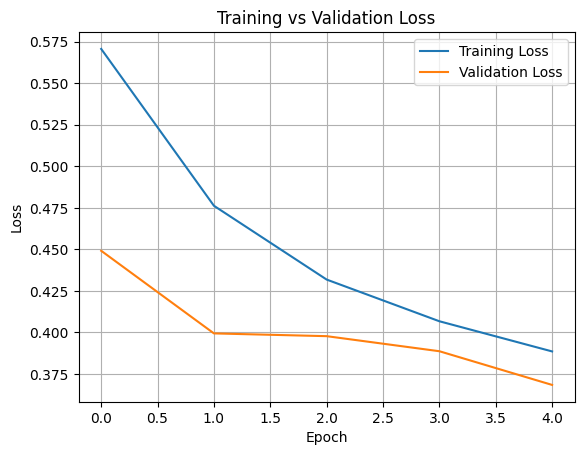

In [39]:
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
import torch.nn.functional as F
def prediction(model, vocab, text):
  clean = clean_text(text)
  tokenized_text = preprocess_text(clean)
  numerical_text=[]
  for word in tokenized_text:
    if word in vocab.keys():
        numerical_text.append(torch.tensor([vocab[word]], dtype=torch.long))
    else:
       numerical_text.append(torch.tensor([vocab['<UNK>']],dtype=torch.long))

  numerical_text = numerical_text[:512]
  if len(numerical_text)<512:
    numerical_text = numerical_text + ([0] * (512 - len(numerical_text)))

  
  numerical_text = torch.tensor(numerical_text,dtype=torch.long)
    # Add batch dimension
  final_text = numerical_text.unsqueeze(0).to(device)  # shape: [1, seq_len]



  output = model(final_text)
  _, prediction = torch.max(output, dim=1)
  pred_prob = F.softmax(output, dim=1).detach().cpu().numpy().reshape(2)

  class_name = ['negative','positive']
  data = {"class_name":class_name ,"value":pred_prob}

  df = pd.DataFrame(data)

  sns.barplot(x='value',y='class_name',data=df,orient='h')
  plt.xlim([0,1])
  plt.xlabel('probability')
  plt.ylabel('sentiment')
  plt.show()

  print(f"Review text: {text}")
  print(f"negative : {pred_prob[0]:0.4f} , positive : {pred_prob[1]:0.4f}")
  print(f"Sentiment  : {class_name[prediction]}")

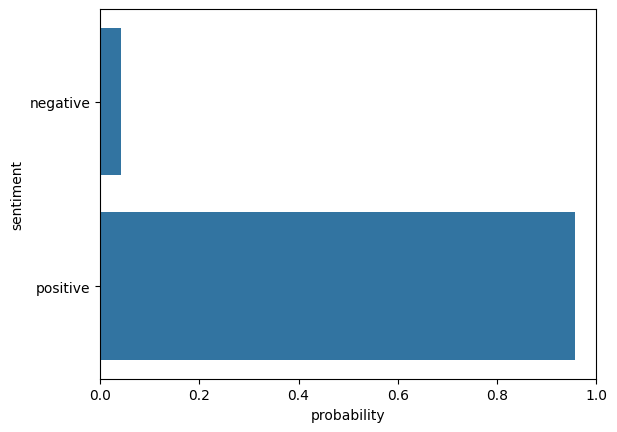

Review text: unexpected ending but pretty good watch
negative : 0.0423 , positive : 0.9577
Sentiment  : positive


In [41]:
prediction(model,vocab,"unexpected ending but pretty good watch")

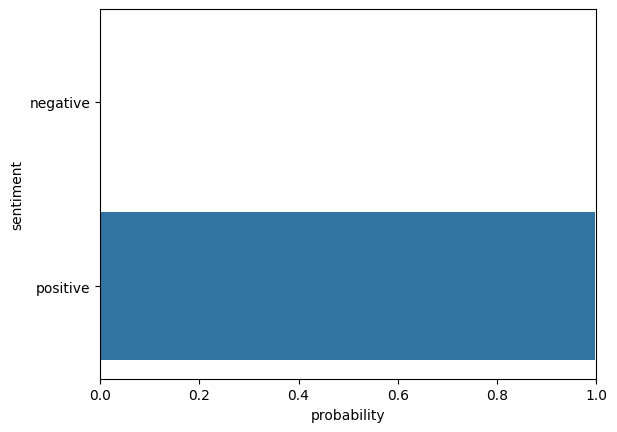

Review text: movie is best of all time
negative : 0.0020 , positive : 0.9980
Sentiment  : positive


In [42]:
prediction(model,vocab,"movie is best of all time")

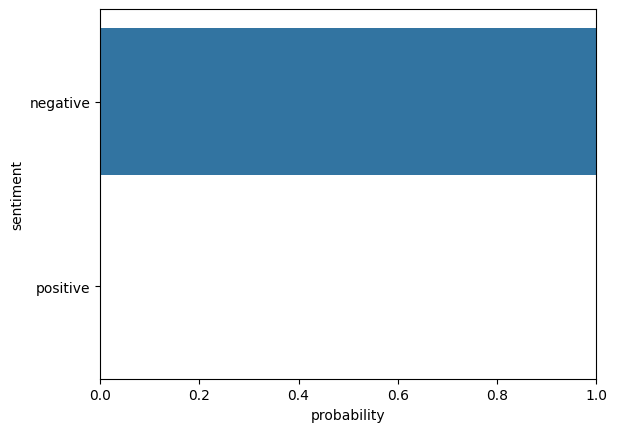

Review text: Ending is terrible
negative : 0.9994 , positive : 0.0006
Sentiment  : negative


In [44]:
prediction(model,vocab,"Ending is terrible")

In [43]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_model(model, val_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)  # Move labels to the device
            outputs = model(x)
            preds = torch.argmax(outputs, dim=1).cpu()
            all_preds.extend(preds.tolist())
            all_labels.extend(y.cpu().tolist())
    acc = accuracy_score(all_labels, all_preds)
    print(f"Validation Accuracy: {acc:.4f}")
    print(classification_report(all_labels, all_preds, target_names=['Negative', 'Positive']))

In [45]:
evaluate_model(model,test_loader,device)

Validation Accuracy: 0.8428
              precision    recall  f1-score   support

    Negative       0.88      0.79      0.83      2500
    Positive       0.81      0.90      0.85      2500

    accuracy                           0.84      5000
   macro avg       0.85      0.84      0.84      5000
weighted avg       0.85      0.84      0.84      5000



In [46]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, val_loader, device):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)
            outputs = model(x)                      # logits
            probs = torch.softmax(outputs, dim=1)   # apply softmax
            positive_probs = probs[:, 1]            # probability of positive class

            all_labels.extend(y.cpu().numpy())
            all_probs.extend(positive_probs.cpu().numpy())

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    # Plot
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


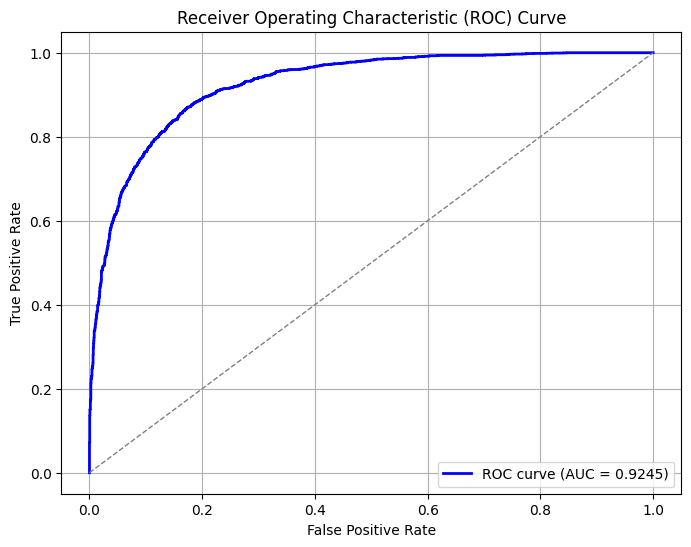

In [47]:
plot_roc_curve(model,test_loader,device)

In [48]:
torch.save(model.state_dict(),"IMDB.pt")